### Importing Libraries

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import littleballoffur as lb

In [7]:
def loadGraph(path):
    G = nx.Graph()
    with open(path) as f:
        for line in f:
            if line.startswith("#"):
                continue
            u, v = map(int, line.strip().split("\t"))
            G.add_edge(u, v)
    return G

def loadCommunity(path, k = None):
    community = {}
    node = set()
    with open(path) as f:
        for id, nodes in enumerate(f):
            if (k is not None) and (id >= k):
                break
            community[id] = list(map(int, nodes.strip().split("\t"))) 
            node.update(set(community[id]))
    return community, node

def inducedSubgraph(G, nodes):
    H = G.subgraph(nodes)
    return H
    

In [11]:
G_DBLP = loadGraph("F:/D/Python/IITGN/CS 328 Introduction to Data Science/Project/CS328-SparseCommunityDetection/Networks/DBLP/com-dblp.ungraph.txt")
communities, nodes = loadCommunity("F:/D/Python/IITGN/CS 328 Introduction to Data Science/Project/CS328-SparseCommunityDetection/Networks/DBLP/com-dblp.top5000.cmty.txt", k = 150)
G_ind_DBLP = inducedSubgraph(G_DBLP, nodes)

print("Number of nodes: ", G_DBLP.number_of_nodes())
print("Number of edges: ", G_DBLP.number_of_edges())
print("Number of communities: ", len(communities))
print("Number of nodes in induced subgraph: ", G_ind_DBLP.number_of_nodes())
print("Number of edges in induced subgraph: ", G_ind_DBLP.number_of_edges())

Number of nodes:  317080
Number of edges:  1049866
Number of communities:  150
Number of nodes in induced subgraph:  1420
Number of edges in induced subgraph:  4609


In [33]:
def plotGraph(graph, title:str = "Graph", with_labels = False, node_size = 5):
    fig = plt.figure(figsize = (12,8))
    nx.draw(graph,with_labels = with_labels, pos = nx.spring_layout(graph), node_size = node_size)
    plt.title(title)
    plt.show()

### Exploring Graph Sampling based on Random Walks 

SRW (Simple Random Walk)

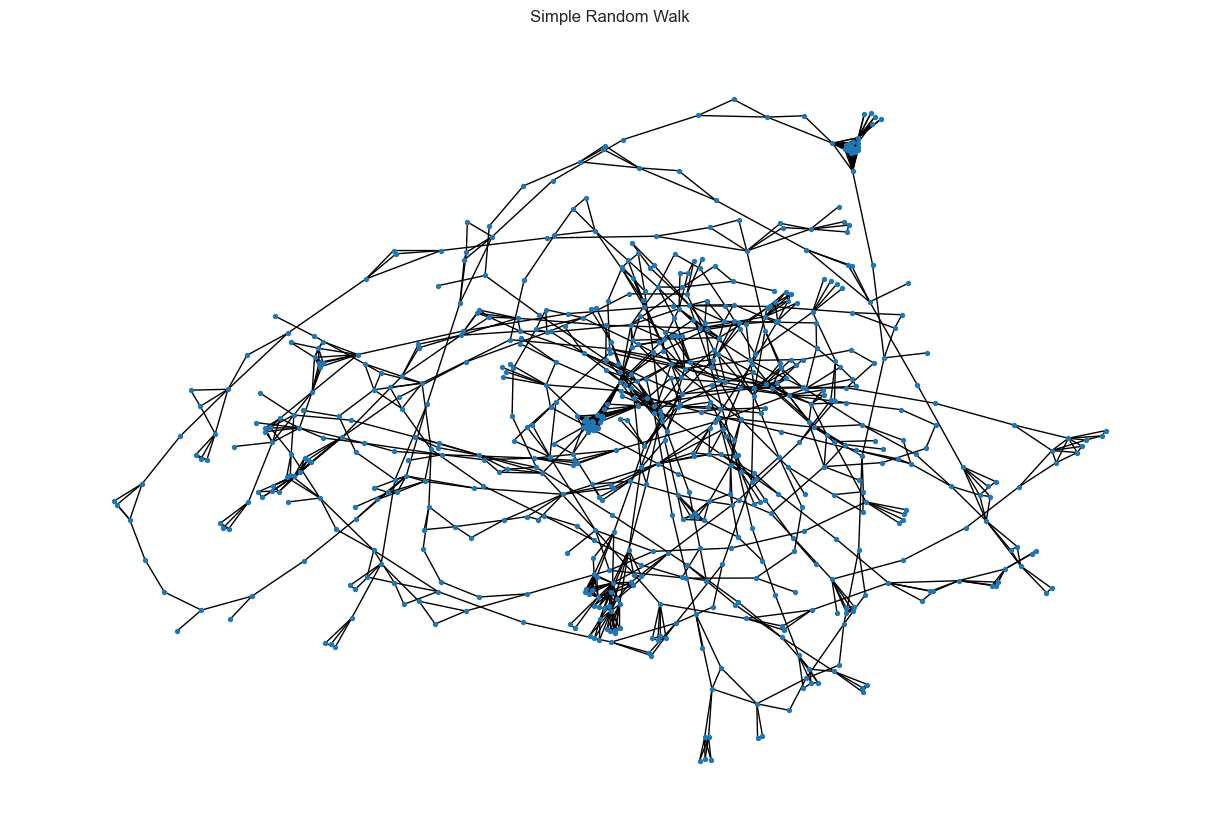

In [37]:
def SRW(graph, total_budget = 1000, seed=None):
    if seed is None:
        seed = np.random.choice(list(graph.nodes()))  # Choose a random seed if not provided

    current_node = seed
    visited_nodes = [current_node]

    budget = 0
    while budget < total_budget:
        neighbors = list(graph.neighbors(current_node))
        if not neighbors:
            break  # If the current node has no neighbors, break out of the loop

        next_node = np.random.choice(neighbors)  # Choose a neighbor uniformly at random
        visited_nodes.append(next_node)

        current_node = next_node
        budget += 1
    
    H = graph.subgraph(set(visited_nodes))
    return visited_nodes, H

random_walk_path, subgraph = SRW(G_DBLP, total_budget = 1000, seed = 1)
plotGraph(subgraph, node_size = 8, title = "Simple Random Walk")

RWR (Random Walk with Restart)

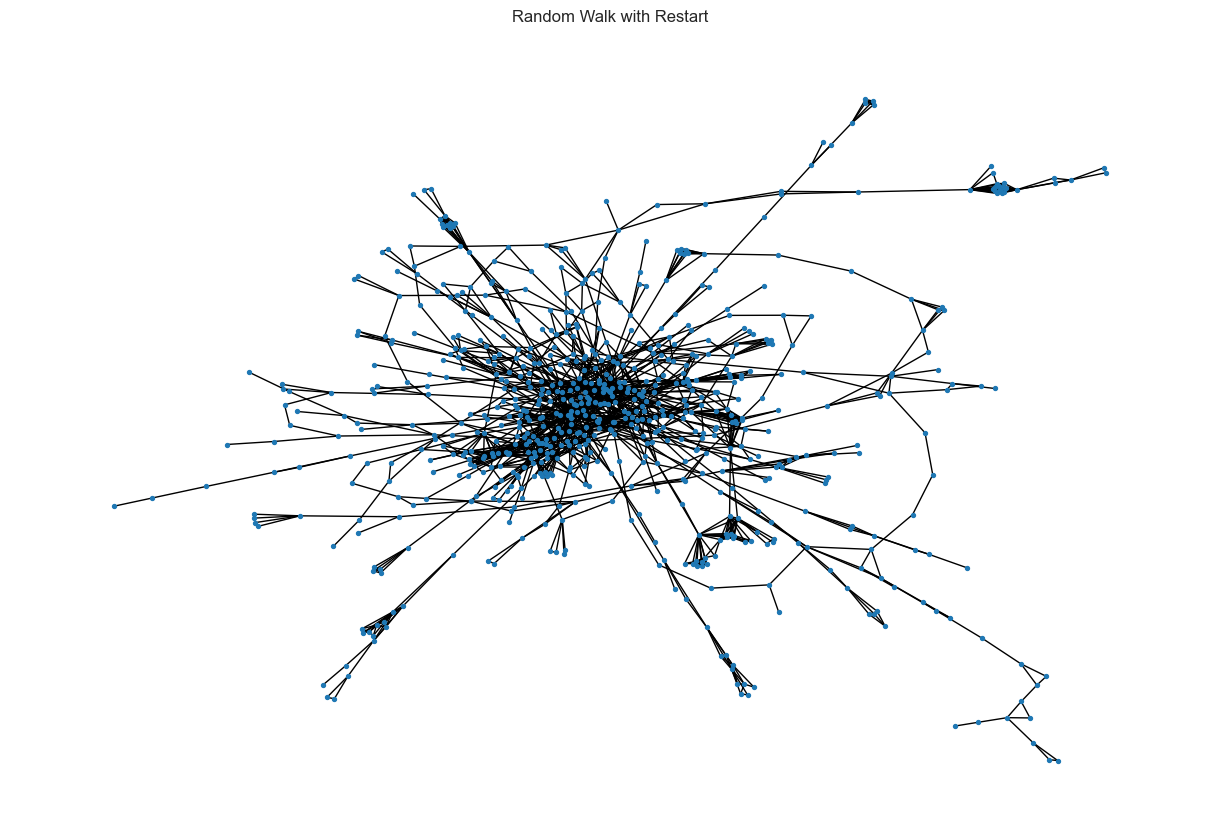

In [38]:
def RWR(graph, total_budget = 1000, restart_prob=0.1, seed=None):
    if seed is None:
        seed = np.random.choice(list(graph.nodes()))  # Choose a random seed if not provided

    current_node = seed
    visited_nodes = [current_node]

    budget = 0
    while budget < total_budget:
        r = np.random.uniform(0, 1)  # Sample a random number between 0 and 1
        if r < restart_prob:
            current_node = seed  # Restart the walk from the seed node
        else:
            neighbors = list(graph.neighbors(current_node))
            if not neighbors:
                break  # If the current node has no neighbors, break out of the loop

            next_node = np.random.choice(neighbors)  # Choose a neighbor uniformly at random
            visited_nodes.append(next_node)
            current_node = next_node

        budget += 1
    H = graph.subgraph(set(visited_nodes))
    return visited_nodes, H

rwr_path, subgraph = RWR(G_DBLP, total_budget = 1000, restart_prob = 0.1, seed  =1)
plotGraph(subgraph, node_size = 8, title = "Random Walk with Restart")

MIRW (Multiple Indpendent Random Walks)

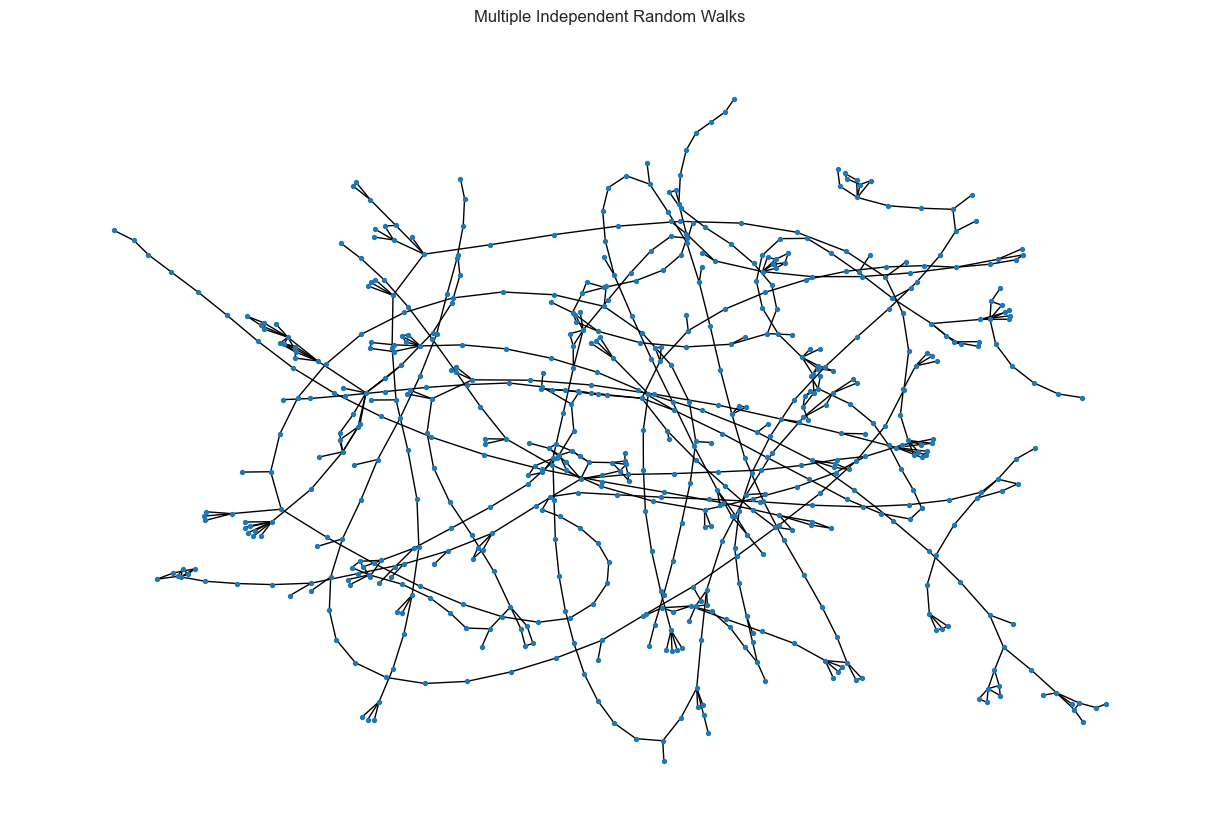

In [46]:
def MIRW(graph, l = 10, budget_per_walk = 100):
    edge_sets = [set() for _ in range(l)]  # Initialize edge sets for each walk
    node_sets = [set() for _ in range(l)]  # Initialize node sets for each walk

    for k in range(l):
        seed = np.random.choice(list(graph.nodes()))  # Choose a random seed for each walk
        current_node = seed
        node_sets[k].add(current_node)

        budget = 0
        while budget < budget_per_walk:
            neighbors = list(graph.neighbors(current_node))
            if not neighbors:
                break  # If the current node has no neighbors, break out of the loop

            next_node = np.random.choice(neighbors)  # Choose a neighbor uniformly at random
            edge_sets[k].add((current_node, next_node))
            node_sets[k].add(next_node)
            current_node = next_node
            budget += 1

    # Combine edge sets and node sets from all walks
    combined_edge_set = set().union(*edge_sets)
    combined_node_set = set().union(*node_sets)

    subgraph = nx.Graph()
    subgraph.add_nodes_from(combined_node_set)
    subgraph.add_edges_from(combined_edge_set)
    return combined_node_set, combined_edge_set, subgraph

nodes, edges, subgraph = MIRW(G_DBLP, l = 10, budget_per_walk = 100)
plotGraph(subgraph, node_size = 8, title = "Multiple Independent Random Walks")

Multi-Dimensional Random Walk (MDRW)

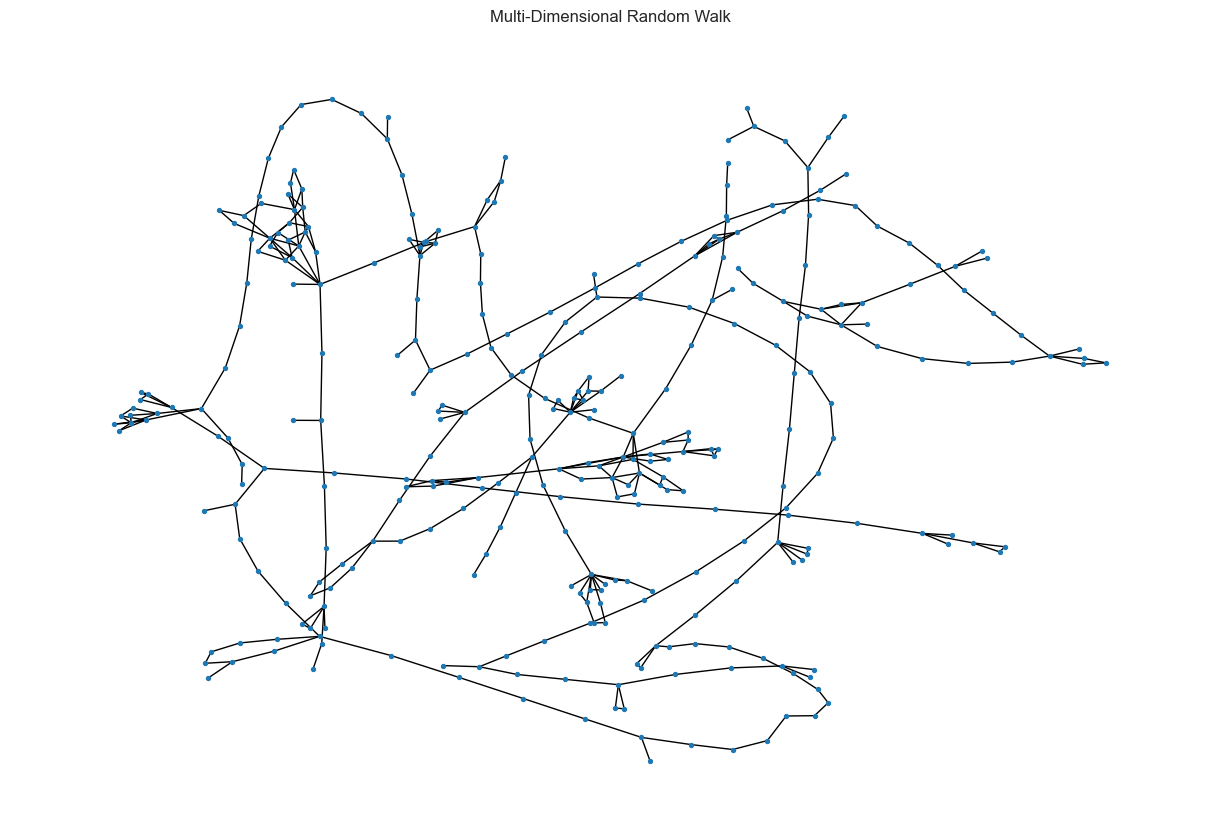

In [59]:
def MDRW(graph, m, total_budget):
    L = np.random.choice(list(graph.nodes()), m)  # Choose m nodes as the initial vector L
    edge_set = set()  # Initialize the edge set
    node_set = set()  # Initialize the node set

    for k in range(total_budget):
        degrees = np.array([graph.degree(node) for node in L])
        probabilities = degrees/np.sum(degrees)
        chosen_node = np.random.choice(L, p=probabilities, size = 1)[0]  # Choose a node proportional to its degree
        neighbors = list(graph.neighbors(chosen_node))
        if not neighbors:
            break  # If the chosen node has no neighbors, break out of the loop

        next_node = np.random.choice(neighbors)  # Choose a neighbor uniformly at random
        edge_set.add((chosen_node, next_node))
        node_set.add(next_node)

        # Replace chosen_node by next_node in the vector L
        L[L == chosen_node] = next_node

    subgraph = nx.Graph()
    subgraph.add_nodes_from(node_set)
    subgraph.add_edges_from(edge_set)

    return node_set, edge_set, subgraph


nodes, edges, subgraph = MDRW(G_DBLP, m = 5, total_budget = 500)
plotGraph(subgraph, node_size = 8, title = "Multi-Dimensional Random Walk")